Import libraries

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2025-05-05 19:24:08.308059: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 19:24:09.548401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746444249.969340    4751 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746444250.078438    4751 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 19:24:10.996415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Monthly forecasts

## Data preparation

In [ ]:
# Explicitly ignore arima warning messages
import warnings
warnings.filterwarnings("ignore")

# Load Data (pasted directly from EMA_SES_2024_tidy.xlsx.coredownload.xlsx)
file_path = "/home/lianlian/webscrape_headlines/monthly_peak.csv"
result_folder = Path("/home/lianlian/webscrape_headlines/results/peak_test")
instance_norm = True

In [3]:
# Read and prepare data
data = pd.read_csv(file_path)
date_col = 'Date'
target_col = 'peak_system_demand_mw'

# This should only run the first time
if 'Date' not in data.columns:
    data['Date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['mth'].astype(str))
    data.drop(['year', 'mth'], axis=1, inplace=True)
    data.to_csv('monthly_peak.csv', index=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
peak_data = data[target_col]
peak_data

Date
2005-01-01    5083
2005-02-01    5285
2005-03-01    5333
2005-04-01    5408
2005-05-01    5385
              ... 
2024-02-01    7673
2024-03-01    7885
2024-04-01    8016
2024-05-01    7989
2024-06-01    7920
Name: peak_system_demand_mw, Length: 234, dtype: int64

<Axes: xlabel='Date', ylabel='peak_system_demand_mw'>

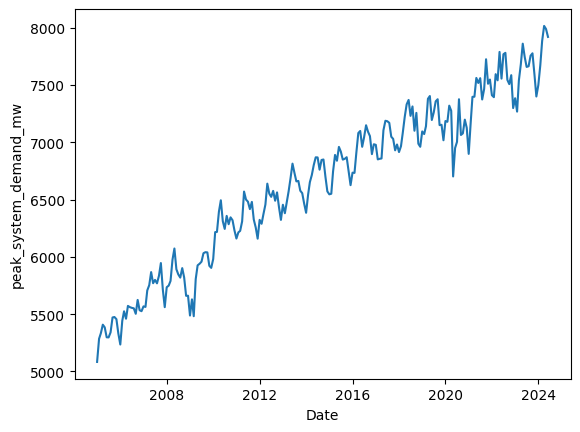

In [4]:
sns.lineplot(data=data, x=date_col, y=target_col)

## ARIMA

In [5]:
# Parameters
window_sizes = [24, 60, 96]  # months window
horizons = [12, 24, 36]  # Predict X steps ahead
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_times = 1
fea_select_flag = 0 # choose with or without feature selection
GPU_ID = 1

In [6]:
# ARIMA parameters
p, d, q, s = 0, 1, 1, 12
result_folder = Path("/home/lianlian/webscrape_headlines/results/peak_test")
arima_folder = result_folder / 'ARIMA'
arima_folder.mkdir(exist_ok=True, parents=True)

In [7]:
# Calculate the start of test period (last 20% of data)
test_size = int(len(peak_data) * 0.2)
test_start_idx = len(peak_data) - test_size

mapes_dfs = pd.DataFrame()
for horizon in horizons:
    mapes = []

    for window_size in window_sizes:
        # Initialize arrays to store predictions and actual values
        predictions = []
        actuals = []
        dates = []

        # Rolling window prediction for last 20% of data
        for i in range(test_start_idx, len(peak_data) - horizon + 1):
            # Extract window - use X months before the prediction point
            train_window = peak_data[i - window_size:i]

            # Fit model on window
            model = ARIMA(train_window, order=(p, d, q), seasonal_order=(p, d, q, s))
            model_fit = model.fit()

            # Make prediction
            forecast = model_fit.forecast(steps=horizon)
            predictions.extend(forecast)

            # Store actual value
            actual = peak_data[i:i + horizon]
            actuals.extend(actual)
            assert len(forecast) == len(actual)
            dates.extend(peak_data.index[i:i + horizon])

        # Convert to arrays for easier handling
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        dates = np.array(dates)

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(peak_data.index, peak_data, label='Historical Data', alpha=0.7)
        for i in range(len(predictions) // horizon):
            plt.plot(dates[i*horizon:i*horizon+horizon], predictions[i*horizon:i*horizon+horizon], linestyle='--')
        plt.axvline(x=peak_data.index[test_start_idx], color='r', linestyle=':', label='Test Period Start')
        plt.title(f'Rolling Window ARIMA Predictions\nWindow Size: {window_size} months, Last 20% of peak_data')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)

        # Save plot
        plot_file = os.path.join(arima_folder, f"Rolling_ARIMA_w{window_size}_pl{horizon}.png")
        plt.savefig(plot_file, dpi=300)
        plt.close()

        # Save predictions to DataFrame
        results_df = pd.DataFrame({
            'Actual': actuals,
            'Predicted': predictions,
            'AbsoluteError': np.abs(actuals - predictions),
            'PercentageError': np.abs((actuals - predictions) / actuals) * 100
        }, index=dates)

        # Calculate metrics
        mape = mean_absolute_percentage_error(actuals, predictions) * 100
        print(f"Rolling Window MAPE: {mape:.2f}%")
        mapes.append(mape)

        # Save to Excel
        excel_file = os.path.join(arima_folder, f"rolling_arima_w{window_size}_pl{horizon}.xlsx")
        results_df.to_excel(excel_file)
        print(f"Results saved to {excel_file}")

        # Additional analysis
        print("Error Analysis:")
        print(f"Mean Absolute Error: {np.mean(np.abs(actuals - predictions)):.2f}")
        print(f"Mean Percentage Error: {np.mean((predictions - actuals) / actuals * 100):.2f}%")
        print(f"Standard Deviation of Absolute Error: {np.std(np.abs(actuals - predictions)):.2f}\n")

    mapes_dfs["MAPE_step"+str(horizon)] = mapes

mapes_dfs.set_index(pd.Series(window_sizes, name='lookback'), inplace=True)
mapes_dfs.to_csv(os.path.join(arima_folder, f".mapes_lookbacks_multiSteps.csv"))

Rolling Window MAPE: 4.56%
Results saved to /home/lianlian/webscrape_headlines/results/peak_test/ARIMA/rolling_arima_w24_pl12.xlsx
Error Analysis:
Mean Absolute Error: 343.21
Mean Percentage Error: 0.37%
Standard Deviation of Absolute Error: 266.59

Rolling Window MAPE: 2.36%
Results saved to /home/lianlian/webscrape_headlines/results/peak_test/ARIMA/rolling_arima_w60_pl12.xlsx
Error Analysis:
Mean Absolute Error: 177.45
Mean Percentage Error: -0.68%
Standard Deviation of Absolute Error: 147.79

Rolling Window MAPE: 2.20%
Results saved to /home/lianlian/webscrape_headlines/results/peak_test/ARIMA/rolling_arima_w96_pl12.xlsx
Error Analysis:
Mean Absolute Error: 165.44
Mean Percentage Error: -0.78%
Standard Deviation of Absolute Error: 132.29

Rolling Window MAPE: 7.57%
Results saved to /home/lianlian/webscrape_headlines/results/peak_test/ARIMA/rolling_arima_w24_pl24.xlsx
Error Analysis:
Mean Absolute Error: 572.36
Mean Percentage Error: 1.56%
Standard Deviation of Absolute Error: 377.59

In [8]:
mapes_dfs

,MAPE_step12,MAPE_step24,MAPE_step36
lookback,,,
24,4.560978,7.568805,9.459062
60,2.357133,3.084919,4.764293
96,2.196674,2.842435,4.445628


## LSTM

In [9]:
# Function to prepare training input sequences
def create_sequences(X, y, window_size, horizons):
    if not instance_norm:
        X_seq, y_seq, scalers = [], [], []
        for i in range(window_size, len(X) - horizons + 1):
            X_seq.append(X[i - window_size:i])
            y_seq.append(y[i:i + horizons])
        return np.array(X_seq), np.array(y_seq), scalers  # dummy var so the func signature stays the same
    else:
        X_seq, y_seq, scalers = [], [], []

        for i in range(window_size, len(X) - horizons + 1):
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            X_window = X[i - window_size:i]
            y_window = y[i:i + horizons]

            X_normalized = scaler_X.fit_transform(X_window)

            scaler_y.fit(X_window[:, :1])
            y_normalized = scaler_y.transform(y_window.reshape(-1, 1))

            X_seq.append(X_normalized)
            y_seq.append(y_normalized)
            scalers.append(scaler_y)

        return np.array(X_seq), np.array(y_seq), scalers

In [10]:
# Paths
lstm_folder = result_folder / 'LSTM'
lstm_folder.mkdir(exist_ok=True, parents=True)

In [11]:
mapes_dfs = pd.DataFrame()
for train_time in range(0, train_times):
    print('training run #:', train_time)

    # Separate input features and target
    X = data.values  # All columns
    y = data.iloc[:, 0].values  # First column is the target price

    if not instance_norm:
        # Scale data
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        X = scaler_X.fit_transform(X)
        y = scaler_y.fit_transform(y.reshape(-1, 1))

    for window_size in window_sizes:
        print("window_size:", window_size)
        mapes = []

        train_length = int(len(X) * train_size)
        val_length = int(len(X) * val_size)
        test_length = int(len(X) * test_size)

        X_train_raw = X[:train_length]
        y_train_raw = y[:train_length]
        X_val_raw = X[train_length - window_size:train_length + val_length]
        y_val_raw = y[train_length - window_size:train_length + val_length]
        X_test_raw = X[train_length + val_length - window_size:train_length + val_length + test_length]
        y_test_raw = y[train_length + val_length - window_size:train_length + val_length + test_length]

        for horizon in horizons:
            print("horizon=", horizon)

            X_train, y_train, scalers_train = create_sequences(X_train_raw, y_train_raw, window_size, horizon)
            X_val, y_val, scalers_val = create_sequences(X_val_raw, y_val_raw, window_size, horizon)
            X_test, y_test, scalers_test = create_sequences(X_test_raw, y_test_raw, window_size, horizon)
            # Y_multi = Y_multi.reshape(Y_multi.shape[0], Y_multi.shape[1])
            n_features = X.shape[1]
            print(X_train.shape)
            print(y_train.shape)

            with tf.device(f'/GPU:{GPU_ID}'):
                # Define the LSTM Network
                model = tf.keras.Sequential([
                    # Input shape should be (window_size, features)
                    tf.keras.layers.LSTM(128, activation='tanh', recurrent_activation='sigmoid',
                                         return_sequences=True, input_shape=(window_size, n_features)),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.LSTM(128, activation='tanh', recurrent_activation='sigmoid'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(horizon)  # Output layer for multi-step predictions
                ])

                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              loss='mse', metrics=['mae'])

                # Train the Model
                history = model.fit(
                    X_train, y_train.reshape(y_train.shape[0], y_train.shape[1]),
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], y_val.shape[1])),
                    epochs=100, batch_size=16, verbose=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True
                        ),
                    ]
                )

                # Make Predictions
                print("X-test shape:", X_test.shape)
                y_pred_scaled = model.predict(X_test)

            # inverse scaling
            if instance_norm:
                y_pred_inverse = np.zeros_like(y_pred_scaled)
                y_test_inverse = np.zeros_like(y_test.reshape(y_test.shape[0], y_test.shape[1]))
                for i, pred in enumerate(y_pred_scaled):
                    y_pred_inverse[i] = scalers_test[i].inverse_transform(pred.reshape(1, -1)).reshape(-1)
                    y_test_inverse[i] = scalers_test[i].inverse_transform(y_test[i].reshape(1, -1)).reshape(-1)
            else:
                y_pred_inverse = scaler_y.inverse_transform(y_pred_scaled)
                y_test_inverse = scaler_y.inverse_transform(y_test)

            # Calculate MAPE
            mape = np.mean(np.abs((y_pred_inverse - y_test_inverse) / y_test_inverse)) * 100
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            mapes.append(mape)

            # Plot historical data
            plt.figure(figsize=(15, 8))
            plt.plot(data.index, data[target_col], label="Historical Demand", color="blue", linewidth=2)

            # Add Test Predictions to the Plot
            start_test_index = int(len(data) * 0.8)
            for i, prediction in enumerate(y_pred_inverse):
                forecast_dates = [data.index[start_test_index + i] + pd.DateOffset(months=j) for j in
                                  range(horizon)]
                plt.plot(forecast_dates, prediction, color="red", marker="o", linestyle="-",
                         label="Predicted" if i == 0 else "")

            plt.title("Monthly Peak Demand Multi-Step Forecasting with LSTM")
            plt.xlabel("Time")
            plt.ylabel("Peak Demand")
            plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
            plt.grid(True)
            plt.tight_layout()

            # Save Plot
            plot_file = os.path.join(lstm_folder, f"LSTM_MultiStep_feat0_lb{window_size}_pl{horizon}.png")
            plt.savefig(plot_file, dpi=300)
            print(f"Plot saved to {plot_file}")
            # plt.show()
            plt.close()

            # Save Results to Excel
            results_df = pd.DataFrame(
                np.column_stack([
                    val for step in range(horizon)
                    for val in [y_test_inverse[:, step], y_pred_inverse[:, step]]
                ]),
                columns=[
                    item for step in range(horizon)
                    for item in [f"True_Step_{step + 1}", f"Predicted_Step_{step + 1}"]
                ]
            )
            results_file = os.path.join(lstm_folder, f"LSTM_MultiStep_feat0_lb{window_size}_pl{horizon}.xlsx")
            results_df.to_excel(results_file, index=False, engine="openpyxl")
            print(f"Results saved to {results_file}")

        mapes_dfs[f"{window_size}"] = mapes

mapes_dfs = mapes_dfs.T
mapes_dfs.set_index(pd.Series(mapes_dfs.index, name='lookback'), inplace=True)
mapes_dfs.columns = [f"MAPE_step{horizon}" for horizon in horizons]
mapes_dfs.to_csv(os.path.join(lstm_folder,".mapes_lookbacks_multiSteps.csv"))

training run #: 0
window_size: 24
horizon= 12
(105, 24, 1)
(105, 12, 1)


I0000 00:00:1746434479.796805  219415 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1746434479.798361  219415 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9616 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1746434482.195539  219727 cuda_dnn.cc:529] Loaded cuDNN version 90300


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.1648 - mae: 1.5157 - val_loss: 1.4602 - val_mae: 0.9523
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.1333 - mae: 1.1612 - val_loss: 1.4002 - val_mae: 0.9809
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4072 - mae: 0.9169 - val_loss: 1.1825 - val_mae: 0.9136
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1238 - mae: 0.8239 - val_loss: 1.1399 - val_mae: 0.9014
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1294 - mae: 0.8221 - val_loss: 1.2039 - val_mae: 0.9261
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1750 - mae: 0.8359 - val_loss: 1.1766 - val_mae: 0.9168
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1741 - mae: 0.8352 - val_loss: 1.1817 - val_mae: 0.9160
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1249 - mae: 0.8099 - val_loss: 1.1321 - val_mae: 0.8972
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1222 - mae: 0.8161 - val

In [12]:
mapes_dfs

,MAPE_step12,MAPE_step24,MAPE_step36
lookback,,,
24,1.938495,1.966174,4.113947
60,1.778186,1.994991,2.176036
96,2.024516,2.142363,2.293379


Additional run for LSTM recursive predictions longer than horizon 36, since we do not have enough data to support doing so. 

This is to be used in the yearly forecast aggregation (in the next section). We don't compare MAPE for this, since it is forecasting outside of our given data range.

In [13]:
# Parameters
window_sizes = [60]  # 60 seems to be the best?
horizons = [36]  # Use the maximum horizon for recursive predictions
recursive_horizon = 120

mapes_dfs = pd.DataFrame()
for train_time in range(0, train_times):
    print('training run #:', train_time)

    # Separate input features and target
    X = data.values  # All columns
    y = data.iloc[:, 0].values  # First column is the target price

    if not instance_norm:
        # Scale data
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        X = scaler_X.fit_transform(X)
        y = scaler_y.fit_transform(y.reshape(-1, 1))

    for window_size in window_sizes:
        print("window_size=", window_size)
        train_length = int(len(X) * train_size)
        val_length = int(len(X) * val_size)
        test_length = int(len(X) * test_size)

        X_train = X[:train_length]
        y_train = y[:train_length]
        X_val = X[train_length - window_size:train_length + val_length]
        y_val = y[train_length - window_size:train_length + val_length]
        X_test = X[train_length + val_length - window_size:train_length + val_length + test_length]
        y_test = y[train_length + val_length - window_size:train_length + val_length + test_length]

        for horizon in horizons:
            print("horizon=", horizon)

            X_train, y_train, scalers_train = create_sequences(X_train, y_train, window_size, horizon)
            X_val, y_val, scalers_val = create_sequences(X_val, y_val, window_size, horizon)
            X_test, y_test, scalers_test = create_sequences(X_test, y_test, window_size, horizon)
            print(X_train.shape)
            print(y_train.shape)
            # Y_multi = Y_multi.reshape(Y_multi.shape[0], Y_multi.shape[1])
            n_features = X.shape[1]

            with tf.device(f'/GPU:{GPU_ID}'):
                # Define the LSTM Network
                model = tf.keras.Sequential([
                    # Input shape should be (window_size, features)
                    tf.keras.layers.LSTM(128, activation='tanh', recurrent_activation='sigmoid',
                                         return_sequences=True, input_shape=(window_size, n_features)),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.LSTM(128, activation='tanh', recurrent_activation='sigmoid'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(horizon)  # Output layer for multi-step predictions
                ])

                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              loss='mse', metrics=['mae'])

                # Train the Model
                history = model.fit(
                    X_train, y_train.reshape(y_train.shape[0], y_train.shape[1]),
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], y_val.shape[1])),
                    epochs=100, batch_size=16, verbose=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True
                        ),
                    ]
                )

            
            # ---------- RECURSIVE FUTURE FORECASTING ----------
            # Do another mini-run, but this time include windows up until the last point of true data
            print("Generating future forecasts...")

            # Create sequences for X only
            X_seq, scalers = [], []
            if not instance_norm:
                for i in range(start_test_index, len(X)):
                    X_seq.append(X[i - window_size + 1:i + 1])
            else:
                for i in range(start_test_index, len(X)):
                    scaler = StandardScaler()
                    X_window = X[i - window_size + 1:i + 1]
                    X_normalized = scaler.fit_transform(X_window)

                    X_seq.append(X_normalized)
                    scalers.append(scaler)
            X_seq = np.array(X_seq)
            
            # Generate future predictions
            print("X-test shape:", X_seq.shape)
            future_preds_scaled = model.predict(X_seq)
            print('future_preds shape:', future_preds_scaled.shape)

            # Initialize array to store extended predictions in original scale
            extended_preds = np.zeros((future_preds_scaled.shape[0], recursive_horizon))
            
            # First denormalize the initial predictions
            if instance_norm:
                for i, pred in enumerate(future_preds_scaled):
                    extended_preds[i, :horizon] = scalers[i].inverse_transform(pred.reshape(1, -1)).flatten()
            else:
                extended_preds[:, :horizon] = scaler_y.inverse_transform(future_preds_scaled)

            # For each sequence, make recursive prediction for all the remaining steps
            for i in range(len(X_seq)):
                current_seq = np.copy(X_seq[i])
                current_pos = horizon
                original_scaler = scalers[i] if instance_norm else None

                # Continue predicting until we reach the recursive_horizon
                while current_pos < recursive_horizon:
                    # Shift window by removing oldest values and adding the most recent predictions
                    current_seq = np.roll(current_seq, -horizon, axis=0)

                    # Ths part assumes only unidimensional predictions - if doing multidimensional, insert extra handling logic
                    if instance_norm:
                        prev_part_unscaled = original_scaler.inverse_transform(current_seq[:-horizon])
                        new_part_unscaled = extended_preds[i, current_pos-horizon:current_pos].reshape(-1, X_seq.shape[2])
                        combined_unscaled = np.vstack([prev_part_unscaled, new_part_unscaled])
                        
                        # Create and fit a new scaler for this new window 
                        new_scaler = StandardScaler()
                        current_seq = new_scaler.fit_transform(combined_unscaled)
                        
                        # Update the scaler for the next iteration
                        original_scaler = new_scaler
                    else:
                        # For global normalization, we can just insert the scaled predictions
                        current_seq[-horizon:] = scaler_y.transform(
                            extended_preds[i, current_pos-horizon:current_pos].reshape(-1, X_seq.shape[2]))
                    
                    # Make new prediction
                    model_input = current_seq.reshape(1, window_size, X_seq.shape[2])
                    next_pred = model.predict(model_input)

                    # Unscale predictions
                    if instance_norm:
                        next_pred_unscaled = original_scaler.inverse_transform(next_pred.reshape(1, -1)).flatten()
                    else:
                        next_pred_unscaled = scaler_y.inverse_transform(next_pred).flatten()
                    
                    # Store the predictions in original scale
                    steps_remaining = recursive_horizon - current_pos
                    steps_to_add = min(horizon, steps_remaining)
                    extended_preds[i, current_pos:current_pos+steps_to_add] = next_pred_unscaled[:steps_to_add]
        
                    # Update position
                    current_pos += steps_to_add

            # Replace future_preds_scaled with extended predictions
            future_preds = extended_preds
            
            # Plot historical data
            plt.figure(figsize=(15, 8))
            plt.plot(data.index, data[target_col], label="Historical Demand", color="blue", linewidth=2)
            
            # Generate future dates
            future_dates = []
            for i, prediction in enumerate(future_preds):
                future_dates.append([data.index[start_test_index + i] + pd.DateOffset(months=j) for j in
                                    range(recursive_horizon)])
                # Add Predictions to the Plot
                plt.plot(future_dates[i], prediction, color="red", marker="o", linestyle="-",
                         label="Predicted" if i == 0 else "")
            future_dates = np.array(future_dates)

            plt.title("Monthly Peak Demand Multi-Step Forecasting with LSTM")
            plt.xlabel("Time")
            plt.ylabel("Peak Demand")
            plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
            plt.grid(True)
            plt.tight_layout()

            # Save Plot
            plot_file = os.path.join(lstm_folder, f"LSTM_FutureForecast_lb{window_size}_pl{recursive_horizon}.png")
            plt.savefig(plot_file, dpi=300)
            print(f"Plot saved to {plot_file}")
            # plt.show()
            plt.close()
            
            # Create identifiers for each element in the first dimension
            rows, cols = future_preds.shape
            identifiers = np.repeat(np.arange(rows), cols)
            identifiers = np.array([f"id_{i}" for i in identifiers])

            # Create and save future forecasts to a separate file
            future_dates = future_dates.flatten()
            future_preds = future_preds.flatten()
            future_df = pd.DataFrame({
                'Date': future_dates,
                'Forecast': future_preds,
                'Group_ID': identifiers,
            })
            
            future_file = os.path.join(lstm_folder, f"LSTM_FutureForecast_lb{window_size}_pl{recursive_horizon}.xlsx")
            future_df.to_excel(future_file, index=False, engine="openpyxl")
            print(f"Future forecasts saved to {future_file}")

training run #: 0
window_size= 60
horizon= 36
(45, 60, 1)
(45, 36, 1)
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 4.6520 - mae: 2.0554 - val_loss: 3.7383 - val_mae: 1.7921
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9697 - mae: 1.8693 - val_loss: 2.4350 - val_mae: 1.3540
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.3258 - mae: 1.3317 - val_loss: 1.2658 - val_mae: 0.8989
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.3823 - mae: 0.9339 - val_loss: 0.9119 - val_mae: 0.7788
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.0351 - mae: 0.8176 - val_loss: 0.6690 - val_mae: 0.6773
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7309 - mae: 0.6822 - val_loss: 0.5029 - val_mae: 0.6030
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5950 - mae: 0.6092 - val_loss: 0.4500 - val_mae: 0.5738
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.5619 - mae: 0.5972 - val_loss: 0.4553 - val_mae: 0.5720
E

I0000 00:00:1746434572.266271  219727 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
future_preds shape: (47, 36)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━

In [14]:
# print('Total length:', len(data))
# print('Train length:', int(len(data) * 0.6))
# print('Val/Test length:', int(len(data) * 0.2))
# print('Test start index:', int(len(data) * 0.8))
# print()
# num_windows_after_seq = (len(data) - window_sizes[0] - horizons[0] + 1)
# print('Number of windows after create_sequences():', num_windows_after_seq)
# print('False test start index:', int(num_windows_after_seq * 0.8) + window_sizes[0] - 1)
# print(187/234)
# print(140/234)
# print(170/234)
# adjusted_frac = 170/234 / 0.8 * 1
# print(adjusted_frac)
# adjusted_test_frac = 1 - (187/234) / adjusted_frac
# print(adjusted_test_frac)
# print((adjusted_frac - adjusted_test_frac))
# print(140/234 / (adjusted_frac - adjusted_test_frac))

# Yearly forecasts

## Data preparation

In [15]:
yearly_peak = data.resample('YS').max()
yearly_peak

,peak_system_demand_mw
Date,
2005-01-01,5475
2006-01-01,5624
2007-01-01,5946
2008-01-01,6073
2009-01-01,6041
2010-01-01,6494
2011-01-01,6570
2012-01-01,6639
2013-01-01,6814


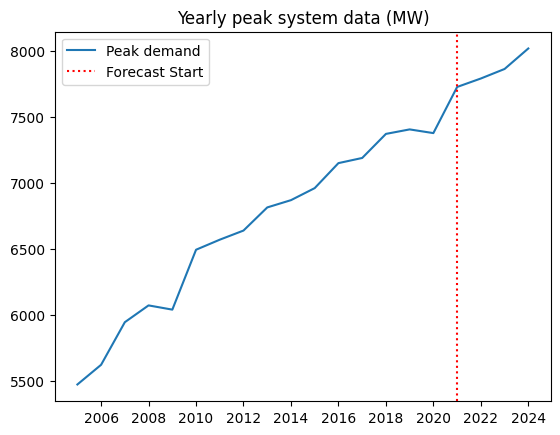

In [16]:
plt.figure()
plt.plot(yearly_peak.index, yearly_peak['peak_system_demand_mw'], label='Peak demand')
plt.axvline(x=yearly_peak.index[int(len(yearly_peak) * 0.8)], color='r', linestyle=':', label='Forecast Start')
plt.title('Yearly peak system data (MW)')
plt.legend()
plt.show()
plt.close()

## ARIMA

In [17]:
# ARIMA parameters
p, d, q = 0, 2, 2
horizon = 10
arima_yearly_folder = result_folder / 'ARIMA_yearly'
arima_yearly_folder.mkdir(exist_ok=True, parents=True)

In [18]:
yearly_peak_data = yearly_peak[target_col]

In [19]:
import matplotlib.dates as mdates

# Calculate the start of test period (last 40% of data)
test_size = int(len(yearly_peak_data) * 0.2)
test_start_idx = len(yearly_peak_data) - test_size

# Get the final date of the true data
final_true_date = yearly_peak_data.index[-1]

# Flag to track when to stop
stop_forecasting = False
exceeded_final_point = False

# Store predictions and actuals for MAPE calculation
all_predictions = []
all_actuals = []
all_dates = []
window_indices = []

# Determine how many windows to process before stopping
max_windows = len(yearly_peak_data) - test_start_idx
processed_windows = 0

# First pass to determine how many windows we'll have before stopping
for i in range(test_start_idx, len(yearly_peak_data)):
    if stop_forecasting:
        break
        
    # Extract window - use all the data before the test point
    train_window = yearly_peak_data[:i]
    
    # Fit model on all historical data
    model = ARIMA(train_window, order=(p, d, q))
    model_fit = model.fit()
    
    # Make prediction
    forecast = model_fit.forecast(steps=horizon)
    
    # Create forecast dates (these may extend beyond the final true date)
    forecast_dates = pd.date_range(start=yearly_peak_data.index[i], periods=horizon, freq=yearly_peak_data.index.freq)
        
    # Store predictions and actuals
    actual = yearly_peak_data[i:i + horizon]
    
    # For MAPE calculation, only include points that don't go beyond the final true date
    valid_forecast_mask = forecast_dates <= final_true_date
    if any(valid_forecast_mask):
        valid_forecasts = forecast[valid_forecast_mask]
        valid_dates = forecast_dates[valid_forecast_mask]
        
        # Get corresponding actual values for these dates
        valid_actuals = []
        for date in valid_dates:
            if date in yearly_peak_data.index:
                valid_actuals.append(yearly_peak_data.loc[date])
            else:
                # If date doesn't exist in actuals, we can't compare
                valid_actuals.append(np.nan)
        
        # Store only non-NaN values for MAPE calculation
        non_nan_mask = ~np.isnan(valid_actuals)
        if any(non_nan_mask):
            all_predictions.extend(valid_forecasts[non_nan_mask])
            all_actuals.extend(np.array(valid_actuals)[non_nan_mask])
            all_dates.extend(valid_dates[non_nan_mask])
            window_indices.extend([i-test_start_idx+1] * sum(non_nan_mask))
    
    processed_windows += 1
    
    # Stop if any forecast point exceeds the final true value and we've gone past the final true date
    if forecast_dates[0] > final_true_date:
        stop_forecasting = True
        print(f"Stopping at window {processed_windows} as forecast exceeds final true value and extends beyond final true date.")

# Create a DataFrame for easier analysis
forecast_df = pd.DataFrame({
    'Date': all_dates,
    'Window': window_indices,
    'Actual': all_actuals,
    'Predicted': all_predictions,
    'Error': np.abs(np.array(all_predictions) - np.array(all_actuals)) / np.array(all_actuals) * 100
})

# Calculate MAPE for all valid predictions
mape = mean_absolute_percentage_error(forecast_df['Actual'], forecast_df['Predicted'])
print(f"Overall MAPE for all valid predictions: {mape * 100:.4f}%")

# Calculate MAPE per window
window_mapes = forecast_df.groupby('Window')['Error'].mean()
print("\nMAPE by full window:")
for window, mape_value in window_mapes.items():
    print(f"Window {window}: {mape_value:.4f}%")

one_step_mapes = forecast_df.groupby('Window')['Error'].first()
print("\nFirst-step Error (1 year prediction):")
for window, one_step_mape_value in one_step_mapes.items():
    print(f"Window {window}: {one_step_mape_value:.4f}%")

# Save MAPE results
mape_file = os.path.join(arima_yearly_folder, f"full_results_pl{horizon}.csv")
forecast_df.to_csv(mape_file)
window_mapes.to_csv(os.path.join(arima_yearly_folder, f"window_mape_pl{horizon}.csv"))

Overall MAPE for all valid predictions: 1.0981%

MAPE by full window:
Window 1: 2.1751%
Window 2: 0.7112%
Window 3: 0.0490%
Window 4: 0.0490%

First-step Error (1 year prediction):
Window 1: 2.0657%
Window 2: 0.9922%
Window 3: 0.0869%
Window 4: 0.0490%


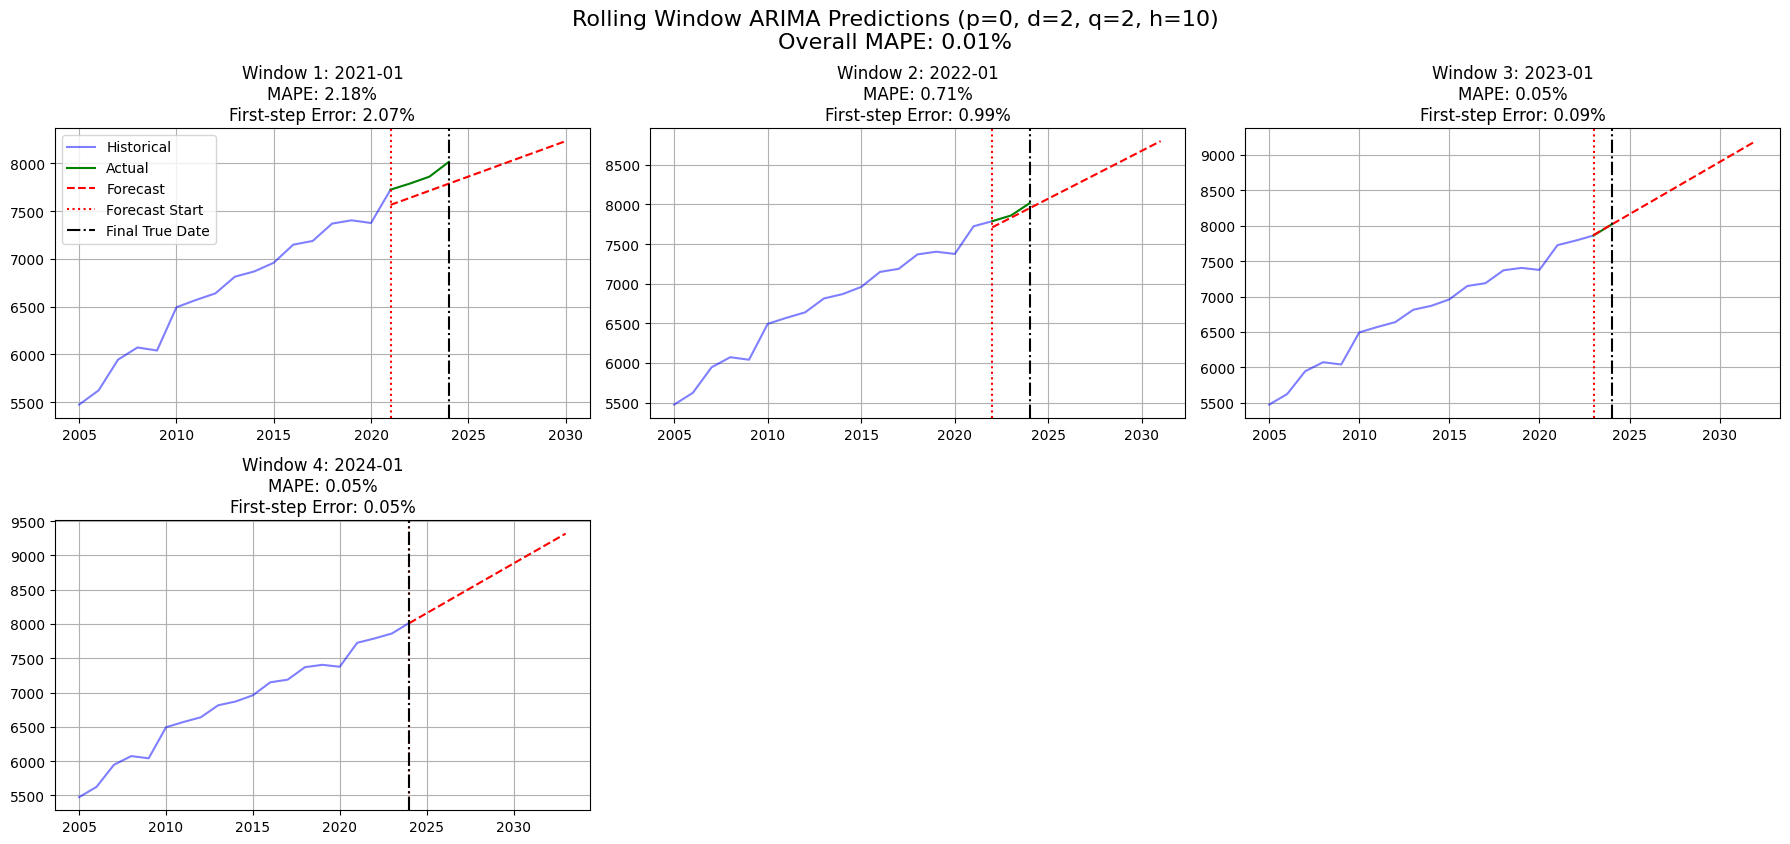

In [20]:
# Create subplots for better visualization
# Determine grid size based on number of windows
import math
n_cols = min(3, processed_windows)  # Max 3 columns
n_rows = math.ceil(processed_windows / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
axes = axes.flatten()

# Reset stop_forecasting flag for the second pass
stop_forecasting = False
exceeded_final_point = False

# Second pass to create the subplots
for idx, i in enumerate(range(test_start_idx, test_start_idx + processed_windows)):
    if idx >= len(axes):
        break
        
    ax = axes[idx]
    
    # Extract window - use all the data before the test point
    train_window = yearly_peak_data[:i]
    
    # Fit model on all historical data
    model = ARIMA(train_window, order=(p, d, q))
    model_fit = model.fit()
    
    # Make prediction
    forecast = model_fit.forecast(steps=horizon)
    
    # Store actual value
    actual = yearly_peak_data[i:i + horizon]
    
    # Create forecast dates
    forecast_dates = pd.date_range(start=yearly_peak_data.index[i], periods=horizon, freq=yearly_peak_data.index.freq)
    
    # Plot historical data
    ax.plot(yearly_peak_data.index[:i + 1], yearly_peak_data[:i + 1], label='Historical', alpha=0.5, color='blue')
    
    # Plot actual test values
    if len(actual) > 0:
        ax.plot(yearly_peak_data.index[i:i+len(actual)], actual, label='Actual', color='green')
    
    # Plot forecast
    ax.plot(forecast_dates, forecast, linestyle='--', label='Forecast', color='red')
    
    # Add vertical line at the test point
    ax.axvline(x=yearly_peak_data.index[i], color='r', linestyle=':', label='Forecast Start')
    
    # Add vertical line at the final true date if forecast extends beyond it
    if forecast_dates[-1] > final_true_date:
        ax.axvline(x=final_true_date, color='black', linestyle='-.', label='Final True Date')
    
    # Add title and MAPE if available
    window_number = i - test_start_idx + 1
    title = f'Window {window_number}: {yearly_peak_data.index[i].strftime("%Y-%m")}'
    if window_number in window_mapes.index:
        title += f'\nMAPE: {window_mapes[window_number]:.2f}%'
        title += f'\nFirst-step Error: {one_step_mapes[window_number]:.2f}%'
    ax.set_title(title)
    
    # Modified X-axis tick configuration - use every nth year
    n_years = 5  # Show every 2 years (modify this number to show fewer ticks)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=n_years))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Only add legend to the first subplot to save space
    if idx == 0:
        ax.legend()
    
    ax.grid(True)

# Hide any unused subplots
for idx in range(processed_windows, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
fig.suptitle(f'Rolling Window ARIMA Predictions (p={p}, d={d}, q={q}, h={horizon})\nOverall MAPE: {mape:.2f}%', 
             fontsize=16, y=1.05)

# Save the subplot figure
subplot_file = os.path.join(arima_yearly_folder, f"Subplots_ARIMA_p{p}d{d}q{q}_h{horizon}.png")
plt.savefig(subplot_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

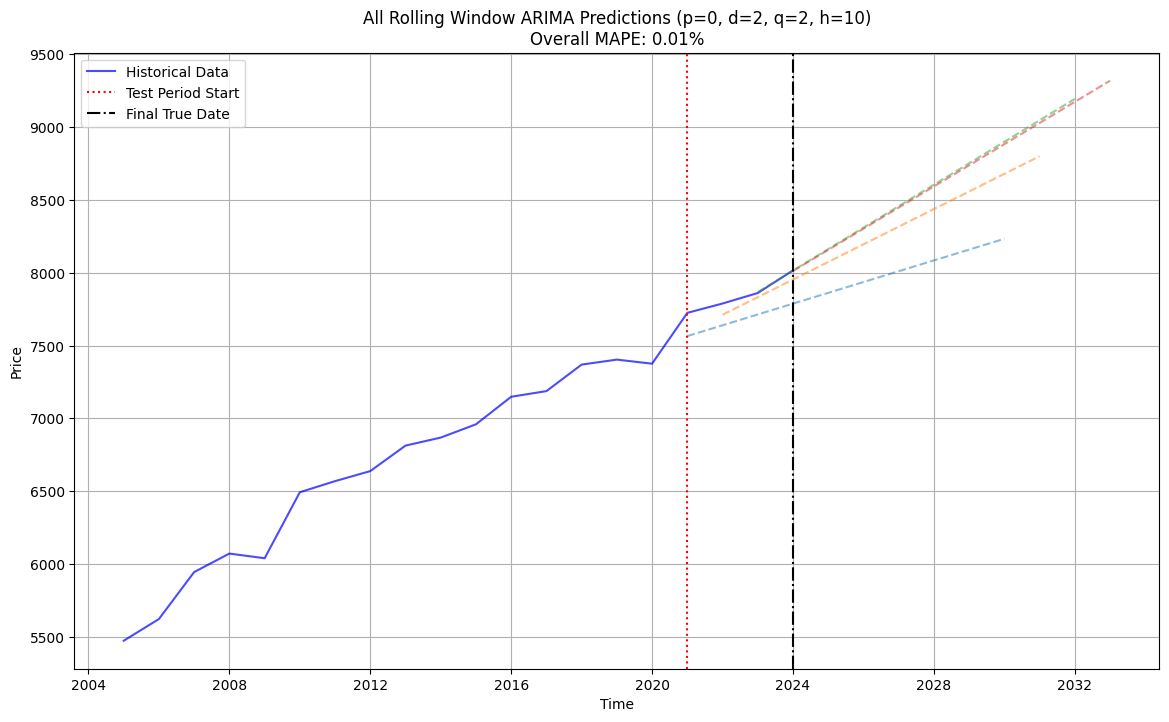

In [21]:
# Create a summary plot showing all windows until the stopping point
plt.figure(figsize=(14, 8))

# Plot all historical data
plt.plot(yearly_peak_data.index, yearly_peak_data, label='Historical Data', alpha=0.7, color='blue')

# Plot all forecasts up to the stopping point
for i in range(test_start_idx, test_start_idx + processed_windows):
    train_window = yearly_peak_data[:i]
    model = ARIMA(train_window, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=horizon)
    forecast_dates = pd.date_range(start=yearly_peak_data.index[i], periods=horizon, freq=yearly_peak_data.index.freq)
    
    plt.plot(forecast_dates, forecast, linestyle='--', alpha=0.5)

# Add vertical line at the test period start
plt.axvline(x=yearly_peak_data.index[test_start_idx], color='r', linestyle=':', label='Test Period Start')

# Add vertical line at the final true date
plt.axvline(x=final_true_date, color='black', linestyle='-.', label='Final True Date')

plt.title(f'All Rolling Window ARIMA Predictions (p={p}, d={d}, q={q}, h={horizon})\nOverall MAPE: {mape:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Modified X-axis tick configuration - use every nth year
n_years = 5  # Show every 2 years (modify this number to show fewer ticks)
ax.xaxis.set_major_locator(mdates.YearLocator(base=n_years))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Save summary plot
summary_plot_file = os.path.join(arima_yearly_folder, f"All_Windows_Summary_p{p}d{d}q{q}_h{horizon}.png")
plt.savefig(summary_plot_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Aggregating LSTM monthly

In [22]:
# Set paths
lstm_yearly_folder = result_folder / 'LSTM_yearly_max'
lstm_yearly_folder.mkdir(exist_ok=True, parents=True)

# Parameters
window_size = 60
prediction_length = 120

In [23]:
# Main execution
print("Processing LSTM results for yearly maximum aggregation...")
print(f"Processing lookback length: {window_size}mo/{window_size//12}y, horizon length: {prediction_length}mo/{prediction_length//12}y\n")

# Function to process LSTM results and map to dates
def process_lstm_results(lb, pl):
    file_path = result_folder / 'LSTM' / f"LSTM_FutureForecast_lb{lb}_pl{pl}.xlsx"
    try:
        # Read the Excel file
        df = pd.read_excel(file_path, sheet_name='Sheet1')
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        df.to_csv(lstm_yearly_folder / f'LSTM_yearly_max_full_lb{lb}_pl{prediction_length}.csv')
        
        # Resample to yearly maximum
        results = df.groupby('Group_ID', as_index=False, sort=False)
        yearly_max = results.resample('YS').max()
        yearly_max = yearly_max.reset_index()
        yearly_max.set_index('Date', inplace=True)
        yearly_max.to_csv(lstm_yearly_folder / f'LSTM_yearly_max_interm_lb{lb}_pl{prediction_length}.csv')

        # Retain only those with four ID values - signalling a full year of predictions, no partials
        category_counts = yearly_max['Group_ID'].value_counts() # Count occurrences of each category
        categories_with_four = category_counts[category_counts == (prediction_length // 12)].index.tolist() # Find categories that appear exactly pl//12 times
        filtered_df = yearly_max[yearly_max['Group_ID'].isin(categories_with_four)] # Filter the dataframe to keep only rows with those categories
        
        # Save yearly maximum data
        filtered_df.to_csv(lstm_yearly_folder / f'LSTM_yearly_max_lb{lb}_pl{prediction_length}.csv')

        return filtered_df
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process LSTM results
yearly_max_df = process_lstm_results(window_size, prediction_length)
# yearly_max_df

yearly_max_df = pd.merge(yearly_max_df, yearly_peak_data, 'left', on='Date')
mape_calc_df = yearly_max_df.dropna()

target = 'peak_system_demand_mw'
forecast = 'Forecast'

# Calculate MAPE for all valid predictions
mape = mean_absolute_percentage_error(mape_calc_df[target], mape_calc_df[forecast])
print(f"Overall MAPE for all valid predictions: {mape * 100:.4f}%")

mape_calc_df['Error'] = np.abs(np.array(mape_calc_df[forecast]) - np.array(mape_calc_df[target])) / np.array(mape_calc_df[target]) * 100

# Calculate MAPE per window
window_mapes = mape_calc_df.groupby('Group_ID', sort=False)['Error'].mean()
print("\nMAPE by full window:")
for window, mape_value in window_mapes.items():
    print(f"Group_ID {window}: {mape_value:.4f}%")

one_step_mapes = mape_calc_df.groupby('Group_ID', sort=False)['Error'].first()
print("\nFirst-step Error (1 year prediction):")
for window, one_step_mape_value in one_step_mapes.items():
    print(f"Group_ID {window}: {one_step_mape_value:.4f}%")

# Save MAPE results
mape_file = os.path.join(arima_yearly_folder, f"full_results_pl{horizon}.csv")
mape_calc_df.to_csv(mape_file)
window_mapes.to_csv(os.path.join(arima_yearly_folder, f"window_mape_pl{horizon}.csv"))

Processing LSTM results for yearly maximum aggregation...
Processing lookback length: 60mo/5y, horizon length: 120mo/10y

Overall MAPE for all valid predictions: 3.3582%

MAPE by full window:
Group_ID id_5: 4.4130%
Group_ID id_17: 3.2251%
Group_ID id_29: 2.0793%
Group_ID id_41: 2.0965%

First-step Error (1 year prediction):
Group_ID id_5: 4.3184%
Group_ID id_17: 2.9795%
Group_ID id_29: 1.7390%
Group_ID id_41: 2.0965%


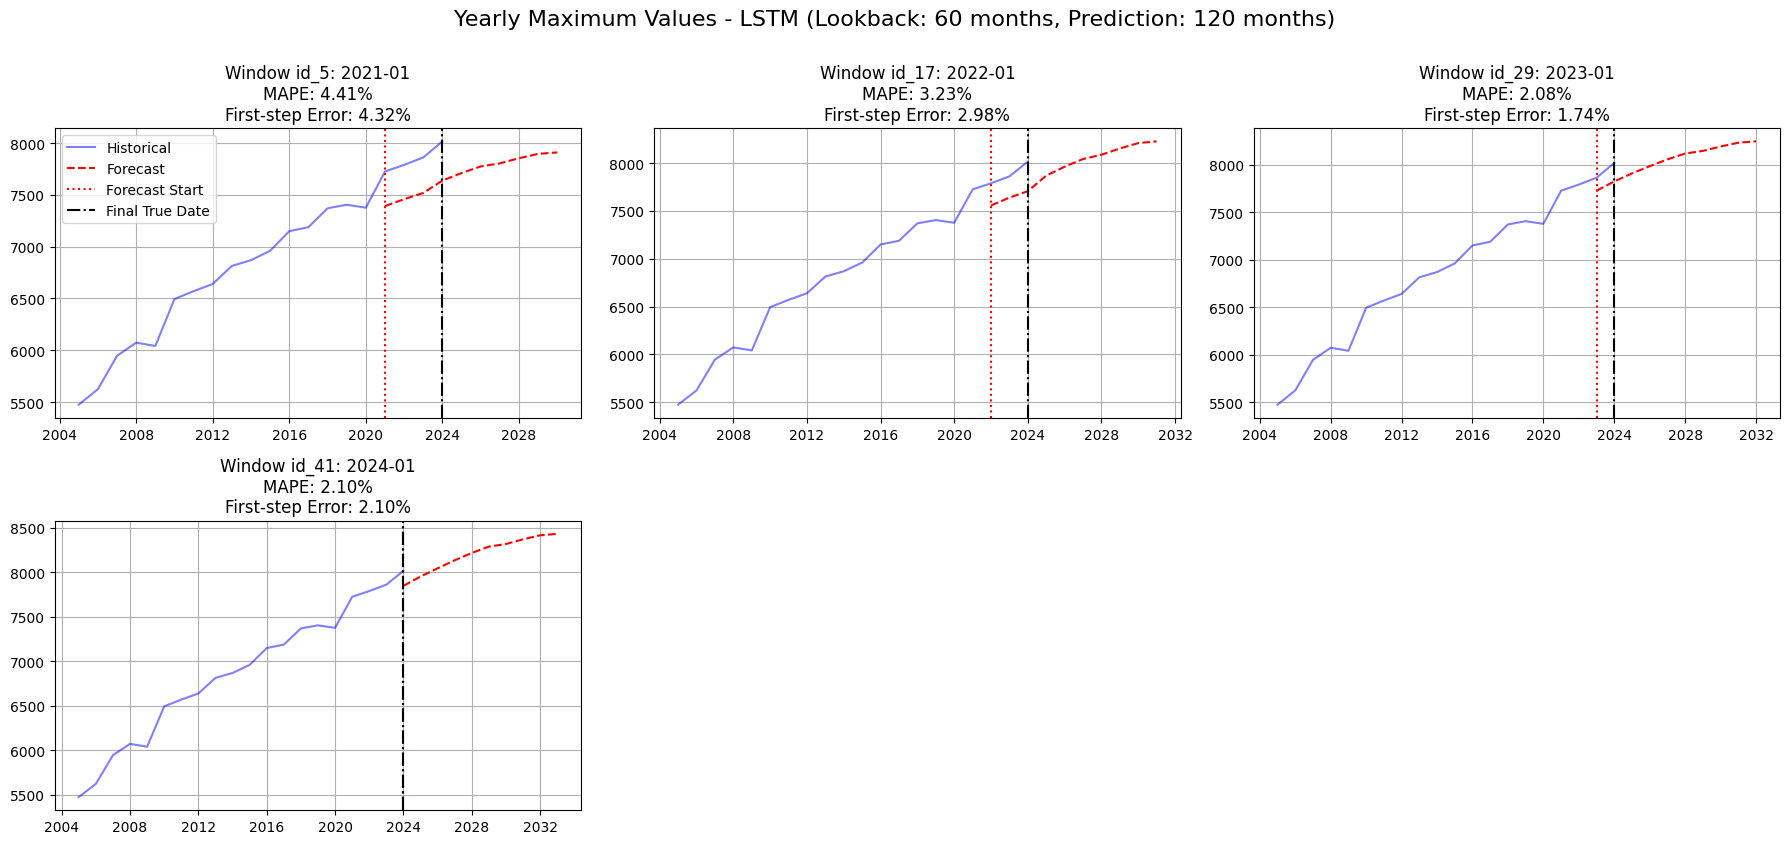

In [24]:
# Function to plot yearly maximum values
def plot_multiple_yearly_max(yearly_data, lb, title=None):
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
    axes = axes.flatten()

    unique_groups = yearly_data['Group_ID'].unique()
    for i, group_id in enumerate(unique_groups):
        group_data = yearly_data[yearly_data['Group_ID'] == group_id]

        # Plot historical data
        axes[i].plot(yearly_peak_data.index, yearly_peak_data, label='Historical', alpha=0.5, color='blue')
        
        # Plot forecast
        axes[i].plot(group_data.index, group_data['Forecast'], linestyle='--', label='Forecast', color='red')
        
        # Add vertical line at the test point
        axes[i].axvline(x=yearly_peak_data.index[test_start_idx + i], color='r', linestyle=':', label='Forecast Start')
        
        # Add vertical line at the final true date if forecast extends beyond it
        axes[i].axvline(x=final_true_date, color='black', linestyle='-.', label='Final True Date')

        # Add title and MAPE if available
        title = f'Window {group_id}: {yearly_peak_data.index[test_start_idx + i].strftime("%Y-%m")}'
        if group_id in window_mapes.index:
            title += f'\nMAPE: {window_mapes[group_id]:.2f}%'
            title += f'\nFirst-step Error: {one_step_mapes[group_id]:.2f}%'
        axes[i].set_title(title)
        
        # Only add legend to the first subplot to save space
        if i == 0:
            axes[i].legend()
        
        axes[i].grid(True)

    # Hide any unused subplots
    for idx in range(len(unique_groups), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    fig.suptitle(f'Yearly Maximum Values - LSTM (Lookback: {lb} months, Prediction: {prediction_length} months)', 
                fontsize=16, y=1.05)

    # Save the subplot figure
    subplot_file = os.path.join(lstm_yearly_folder, f"Subplots_LSTM_p{p}d{d}q{q}_h{horizon}.png")
    plt.savefig(subplot_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_multiple_yearly_max(yearly_max_df, window_size)

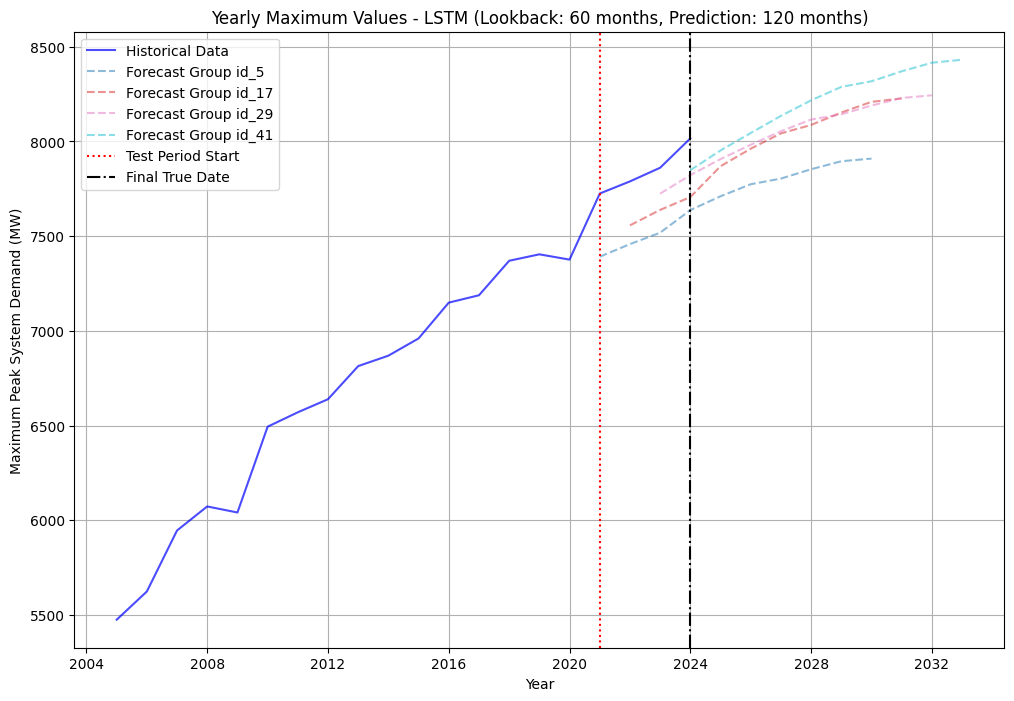

In [25]:
# Function to plot yearly maximum values
def plot_yearly_max(yearly_data, lb, title=None):
    plt.figure(figsize=(12, 8))

    # Plot all historical data
    plt.plot(yearly_peak_data.index, yearly_peak_data, label='Historical Data', alpha=0.7, color='blue')
    
    # Plot forecast data by group
    unique_groups = yearly_data['Group_ID'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))
    
    for i, group_id in enumerate(unique_groups):
        group_data = yearly_data[yearly_data['Group_ID'] == group_id]
        plt.plot(group_data.index, group_data['Forecast'], 
                 linestyle='--', alpha=0.5, color=colors[i], 
                 label=f'Forecast Group {group_id}')
    
    # Add vertical line at the test period start
    plt.axvline(x=yearly_peak_data.index[test_start_idx], color='r', linestyle=':', label='Test Period Start')

    # Add vertical line at the final true date
    plt.axvline(x=final_true_date, color='black', linestyle='-.', label='Final True Date')

    plt.title(title or f'Yearly Maximum Values - LSTM (Lookback: {lb} months, Prediction: {prediction_length} months)')
    plt.xlabel('Year')
    plt.ylabel('Maximum Peak System Demand (MW)')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(lstm_yearly_folder / f'LSTM_yearly_max_lb{lb}_pl{prediction_length}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_yearly_max(yearly_max_df, window_size)
